# Train a JointVAE model

In [27]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
import torch
from viz.visualize import Visualizer
use_cuda = torch.cuda.is_available()
use_cuda

True

In [29]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # change to your device

#### Prepare data list

In [30]:
!ls data

dress_dresslen_train_test_splits.json	dress_sleeve_train_test_splits.json
dress_sleevelen_train_test_splits.json


In [31]:
import json
with open("./data/dress_sleeve_train_test_splits.json", "r") as infile:
    data_dict = json.load(infile)

In [32]:
data_dict.keys()

dict_keys(['X_train_1', 'y_train_1', 'X_test_1', 'y_test_1', 'X_train_2', 'y_train_2', 'X_test_2', 'y_test_2', 'X_train_3', 'y_train_3', 'X_test_3', 'y_test_3', 'X_train_4', 'y_train_4', 'X_test_4', 'y_test_4', 'X_train_5', 'y_train_5', 'X_test_5', 'y_test_5', 'X_train_6', 'y_train_6', 'X_test_6', 'y_test_6', 'X_train_7', 'y_train_7', 'X_test_7', 'y_test_7', 'X_train_8', 'y_train_8', 'X_test_8', 'y_test_8', 'X_train_9', 'y_train_9', 'X_test_9', 'y_test_9', 'X_train_10', 'y_train_10', 'X_test_10', 'y_test_10'])

In [33]:
data_dict['X_train_1'][:5]

['/2/8/2893552_3773662.jpg',
 '/2/4/2431229_3158108.jpg',
 '/2/9/2982376_3889235.jpg',
 '/3/6/3676414_8284307.jpg',
 '/2/7/2783355_3578973.jpg']

#### Create list of image paths

In [34]:
!python -V

Python 3.6.3 :: Anaconda, Inc.


In [35]:
image_paths_train = []
image_paths_test = []

root_data_dir = "/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables"

for key, val in data_dict.items():
    if 'X_train' in key:
        image_paths_train.extend([root_data_dir + imgpath for imgpath in val])
    elif 'X_test' in key:
        image_paths_test.extend([root_data_dir + imgpath for imgpath in val])

print(f"Number of train image paths: {len(image_paths_train):,d}")
print(f"Number of test image paths: {len(image_paths_test):,d}")
print()
print("Sample paths:")
print(image_paths_train[0])
print(image_paths_train[-1])
print(image_paths_test[0])
print(image_paths_test[-1])

Number of train image paths: 207,603
Number of test image paths: 23,067

Sample paths:
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/8/2893552_3773662.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/7/2713940_3640098.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/8/2856150_3749586.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/3/0/3058817_8191784.jpg


In [36]:
#from utils.dataloaders import get_mnist_dataloaders, get_fashion_mnist_dataloaders
#train_loader, test_loader = get_mnist_dataloaders(batch_size=64)
#train_loader, test_loader = get_fashion_mnist_dataloaders(batch_size=64)

In [37]:
from torchvision import transforms
from utils.dataloaders_custom import get_imagelist_dataloader, ImageListDataset

BATCH_SIZE=2048

#composed = transforms.Compose([transforms.Resize((260,260)), transforms.ToTensor()])
composed = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

train_dataset = ImageListDataset(image_paths_train, transform=composed)
test_dataset = ImageListDataset(image_paths_test, transform=composed)

train_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=train_dataset)
test_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=test_dataset)

### Define latent distribution of the model

In [38]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 8,
               'disc': [8]}

### Build a model

In [39]:
#from jointvae.models_v1 import VAE
from jointvae.models import VAE

#model = VAE(latent_spec=latent_spec, img_size=(3, 260, 260), use_cuda=use_cuda)
model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64), use_cuda=use_cuda)

In [40]:
print(model)

VAE(
  (img_to_features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (features_to_hidden): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_mean): Linear(in_features=256, out_features=8, bias=True)
  (fc_log_var): Linear(in_features=256, out_features=8, bias=True)
  (fc_alphas): ModuleList(
    (0): Linear(in_features=256, out_features=8, bias=True)
  )
  (latent_to_features): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
  )
  (features_to_img): Sequential(
    (0): ConvTranspose2d(

### Train the model

In [42]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=7e-5, amsgrad=True) # added amsgrad # orig lr 5e-4

In [43]:
from jointvae.training import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 6.0, 25000, 32.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 6.0, 25000, 32.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,
                 use_cuda=use_cuda)

#### Initialize visualizer

In [44]:
# Build a visualizer which will be passed to trainer to visualize progress during training
viz = Visualizer(model)

In [18]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

trainer.train(train_loader, epochs=10, save_training_gif=('./training_305_64_120e_2048b_8c8d6cc6dc32gam.gif', viz))

features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
0/207603	Loss: 2825.255
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])


features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  to

features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  to

features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  to

features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
102400/207603	Loss: 1442.298
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4,

features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  to

features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  to

features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
0/207603	Loss: 1339.354
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])


features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  to

features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  to

features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  to

features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
102400/207603	Loss: 1333.088
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])
features shape:  torch.Size([2048, 64, 4,

features shape:  torch.Size([755, 64, 4, 4])
features view shape:  torch.Size([755, 1024])
Epoch: 10 Average loss: 1339.93


### Visualize

features shape:  torch.Size([2048, 64, 4, 4])
features view shape:  torch.Size([2048, 1024])


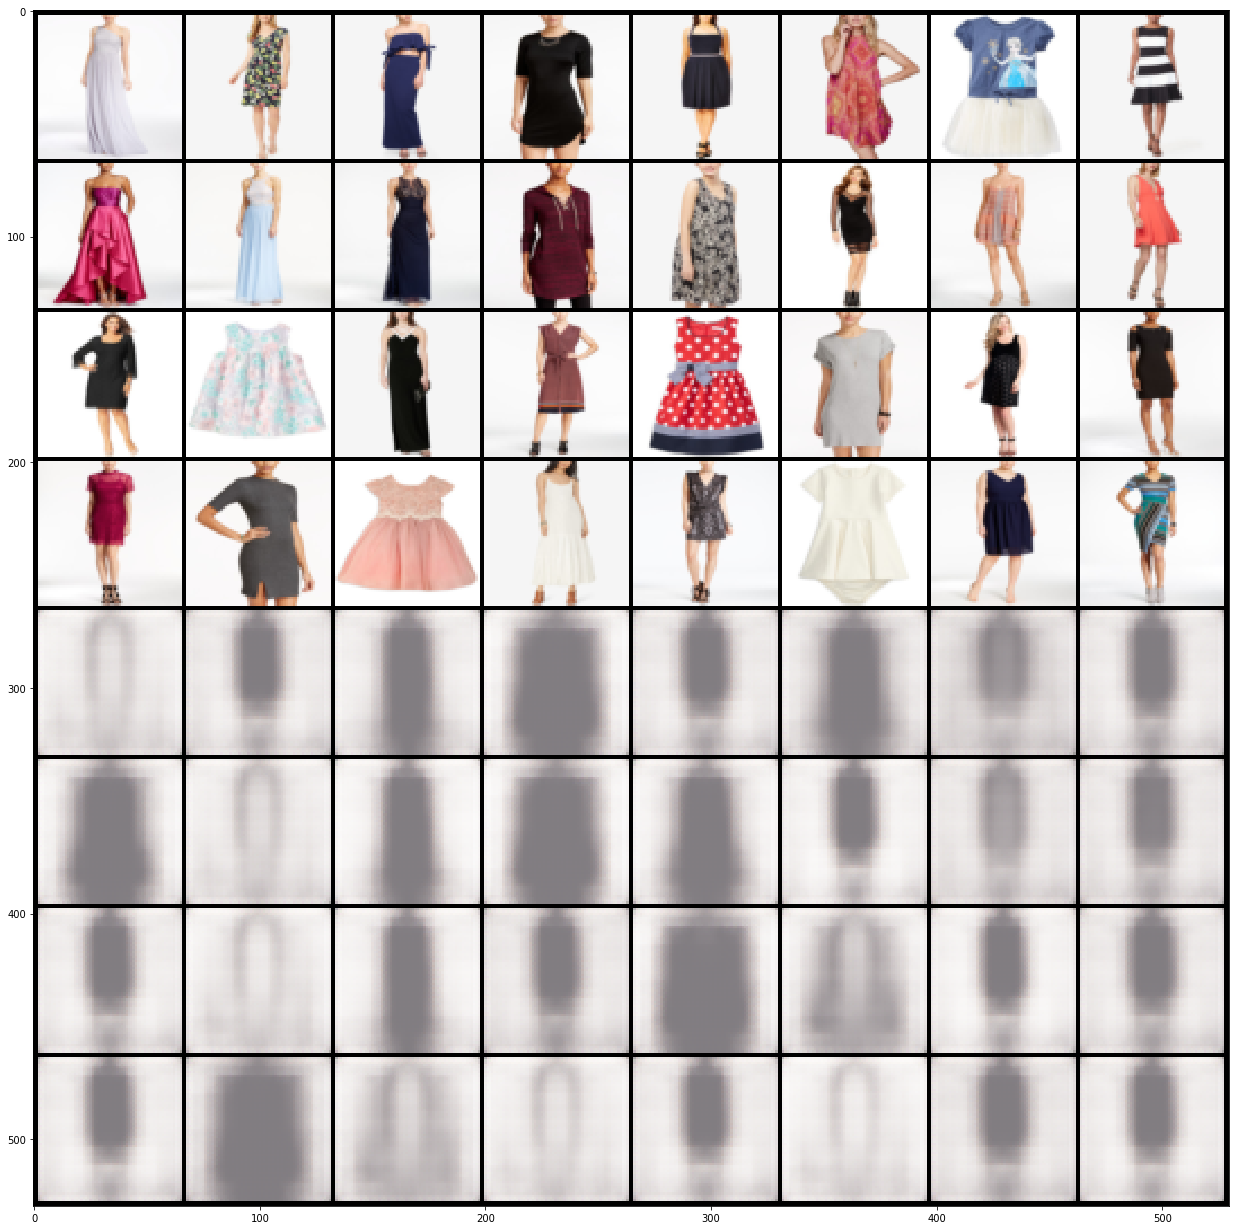

In [21]:
# Plot reconstructions
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Get a batch of data
for batch, labels in test_loader:
    break

# Reconstruct data using Joint-VAE model
recon = viz.reconstructions(batch)

plt.figure(figsize=(22,22))
#plt.imshow(recon.numpy()[0, :, :], cmap='gray');
plt.imshow(np.rot90(np.transpose(recon.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/305/64/e10_b2048_c10c10d6d40_reconstructions.png",dpi=200)

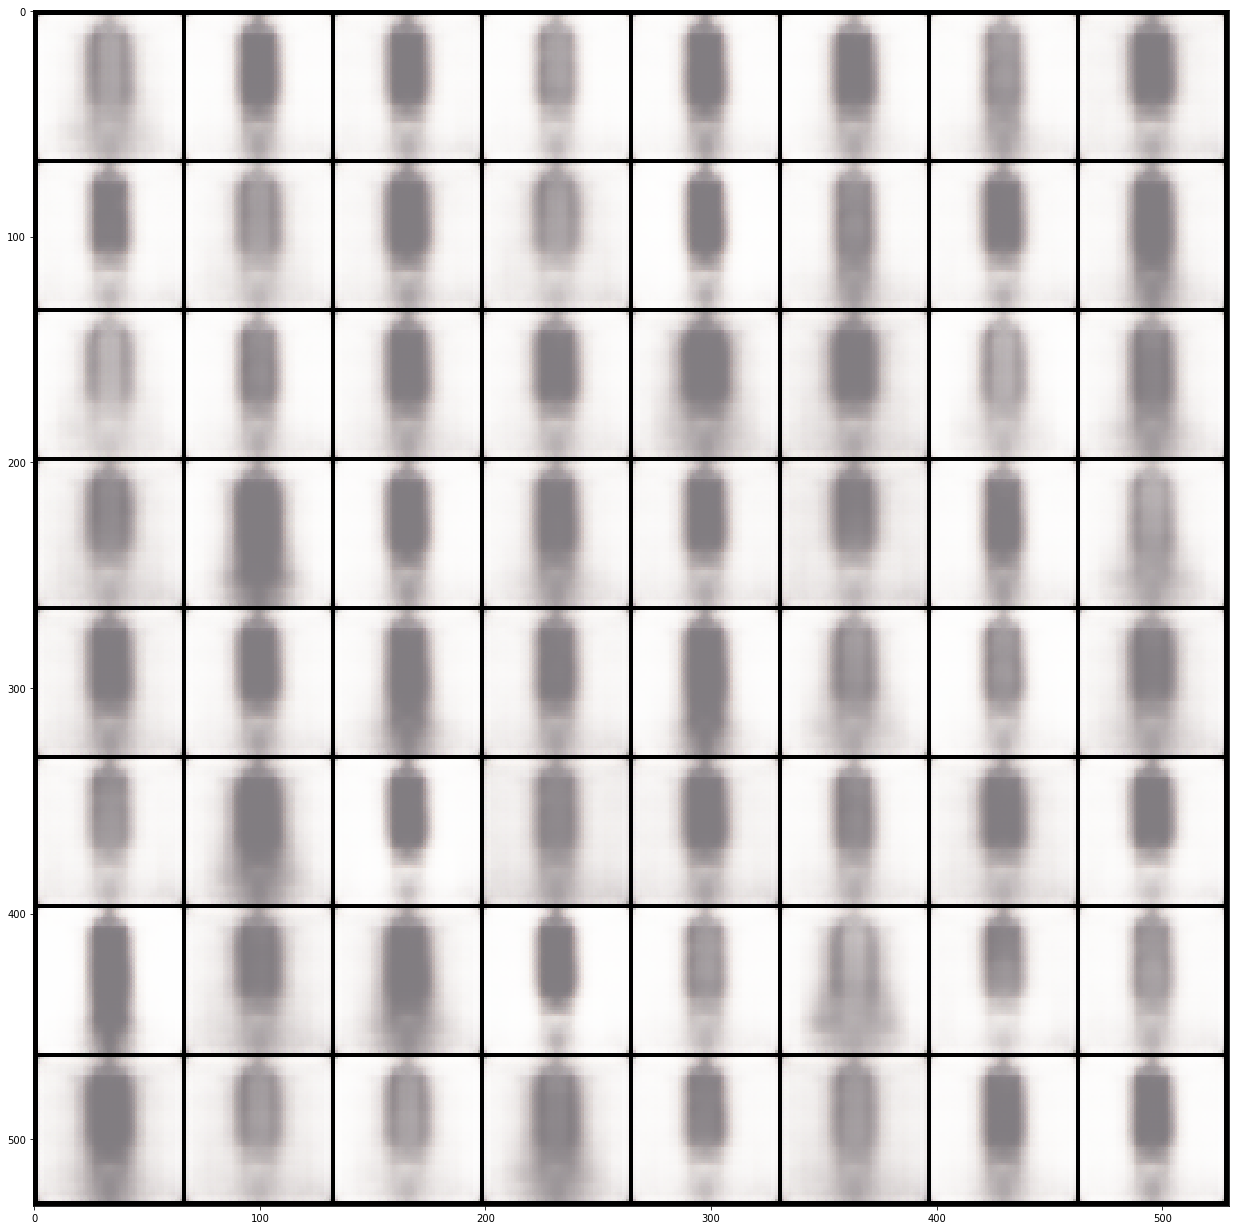

In [22]:
# Plot samples
samples = viz.samples()

#plt.imshow(samples.numpy()[0, :, :], cmap='gray');
plt.figure(figsize=(22,22))
plt.imshow(np.rot90(np.transpose(samples.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/305/64/e10_b2048_c10c10d6d40_samples.png",dpi=200)

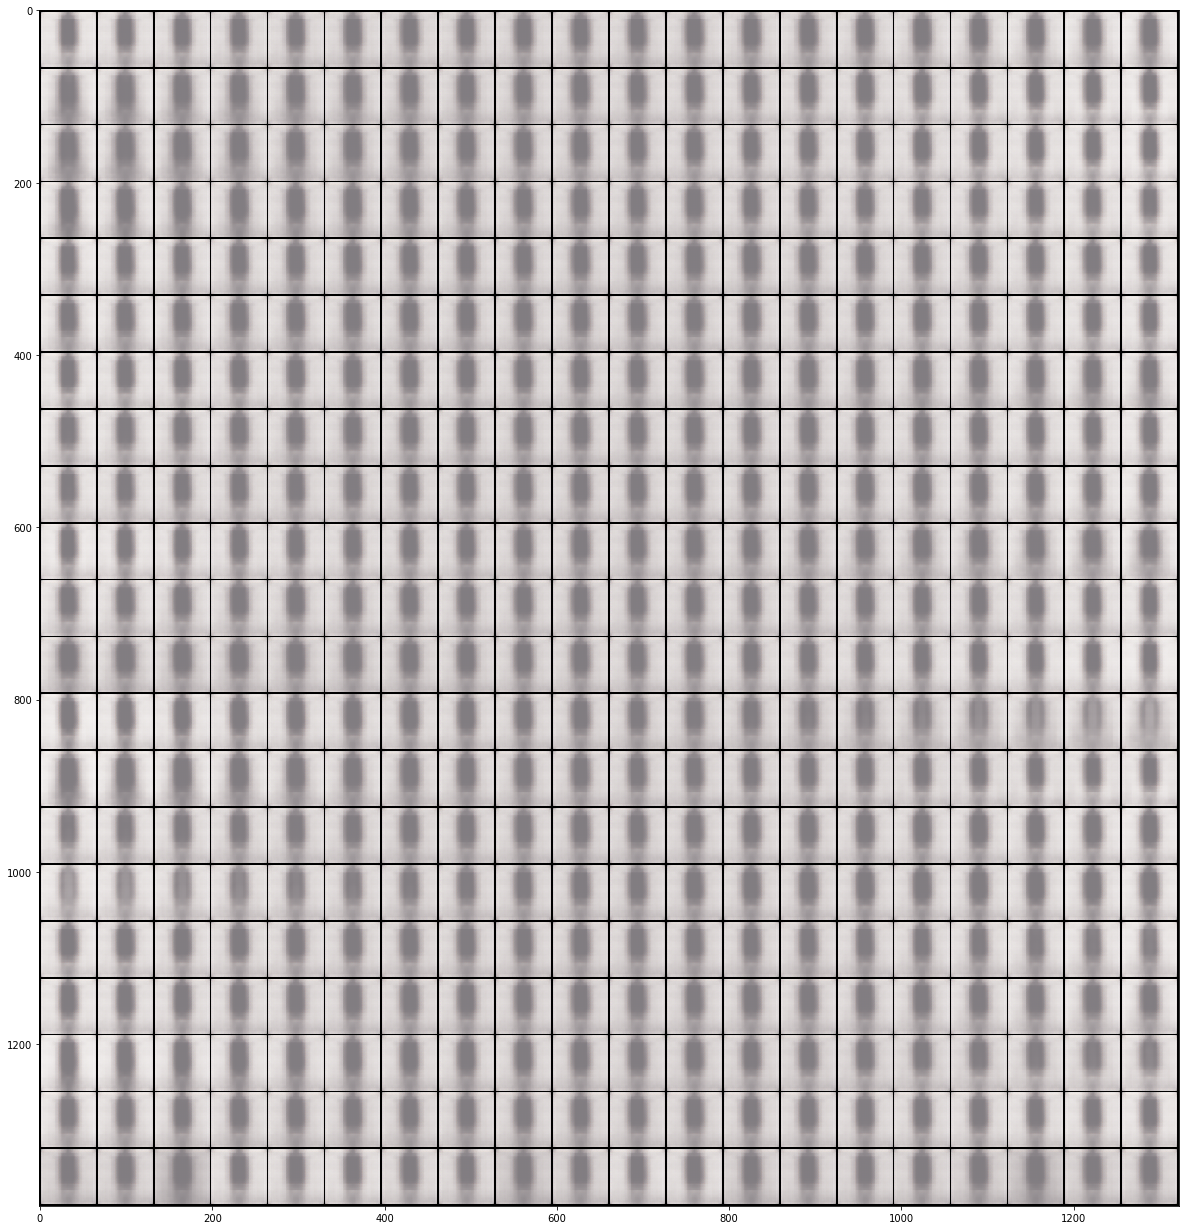

In [23]:
# Plot all traversals
traversals = viz.all_latent_traversals(size=20)

#plt.imshow(traversals.numpy()[0, :, :], cmap='gray');
plt.figure(figsize=(22,22))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/305/64/e10_b2048_c10c10d6d40_all_traversals.png",dpi=200)

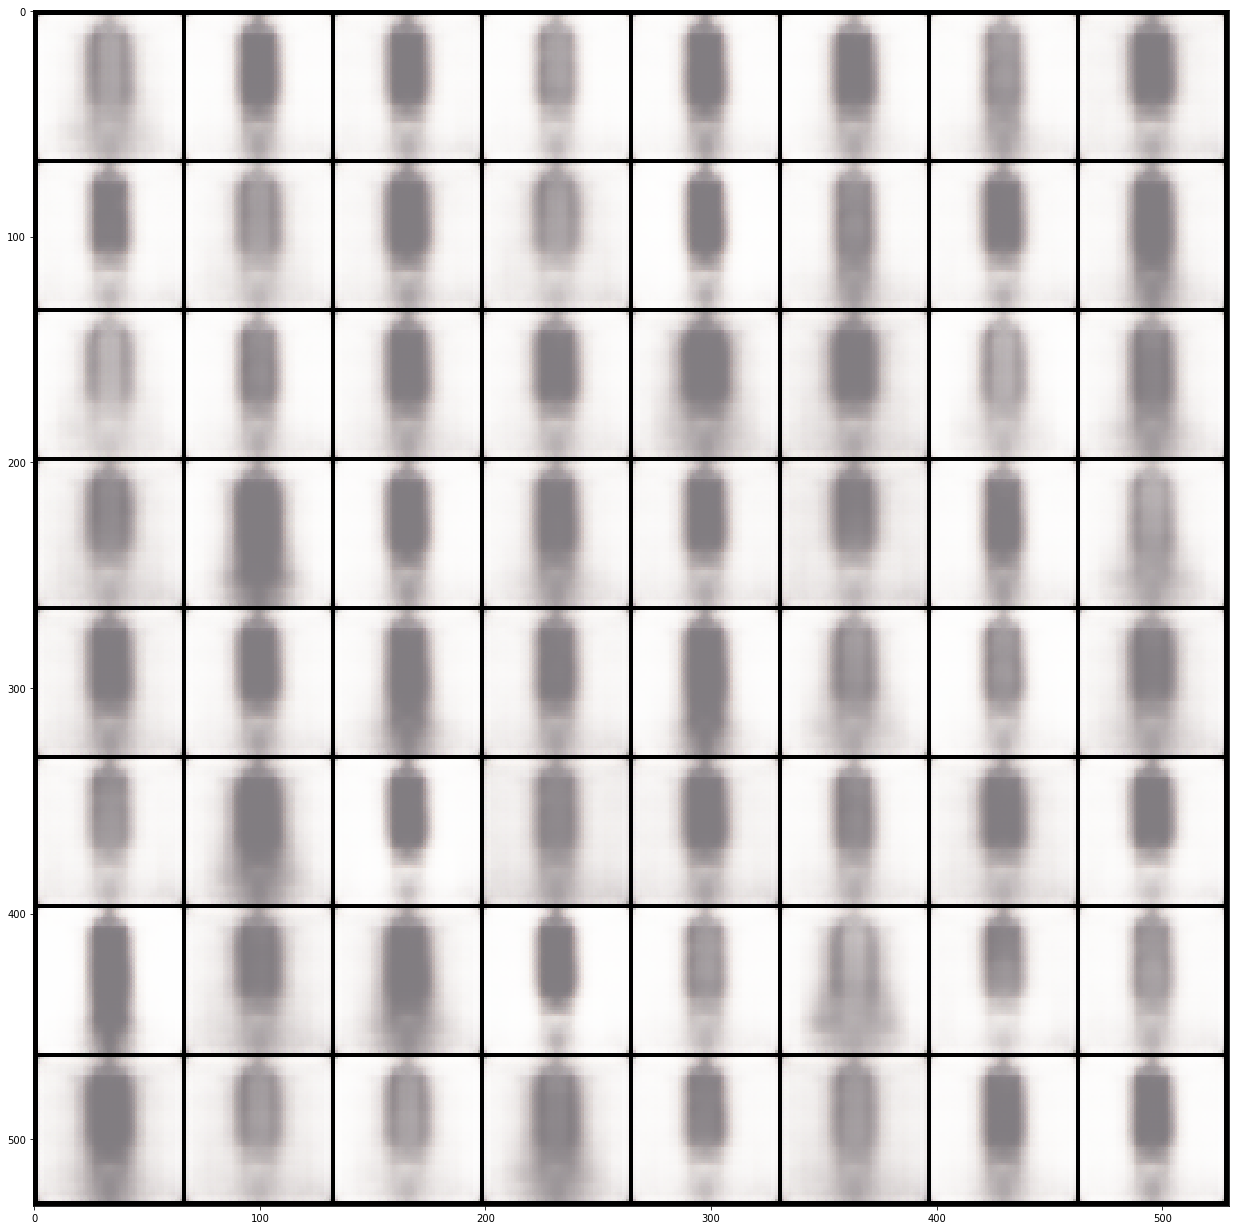

In [25]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, 
                                       disc_idx=0, disc_axis=0, size=(20, 20))

#plt.imshow(traversals.numpy()[0, :, :], cmap='gray');
plt.figure(figsize=(22,22))
plt.imshow(np.rot90(np.transpose(samples.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/305/64/e10_b2048_c10c10d6d40_traversals2100.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=1, cont_axis=1, 
                                       disc_idx=0, disc_axis=0, size=(20, 20))

#plt.imshow(traversals.numpy()[0, :, :], cmap='gray');
plt.figure(figsize=(22,22))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/305/64/e120_b224_c20d20_traversals1100.png",dpi=200)

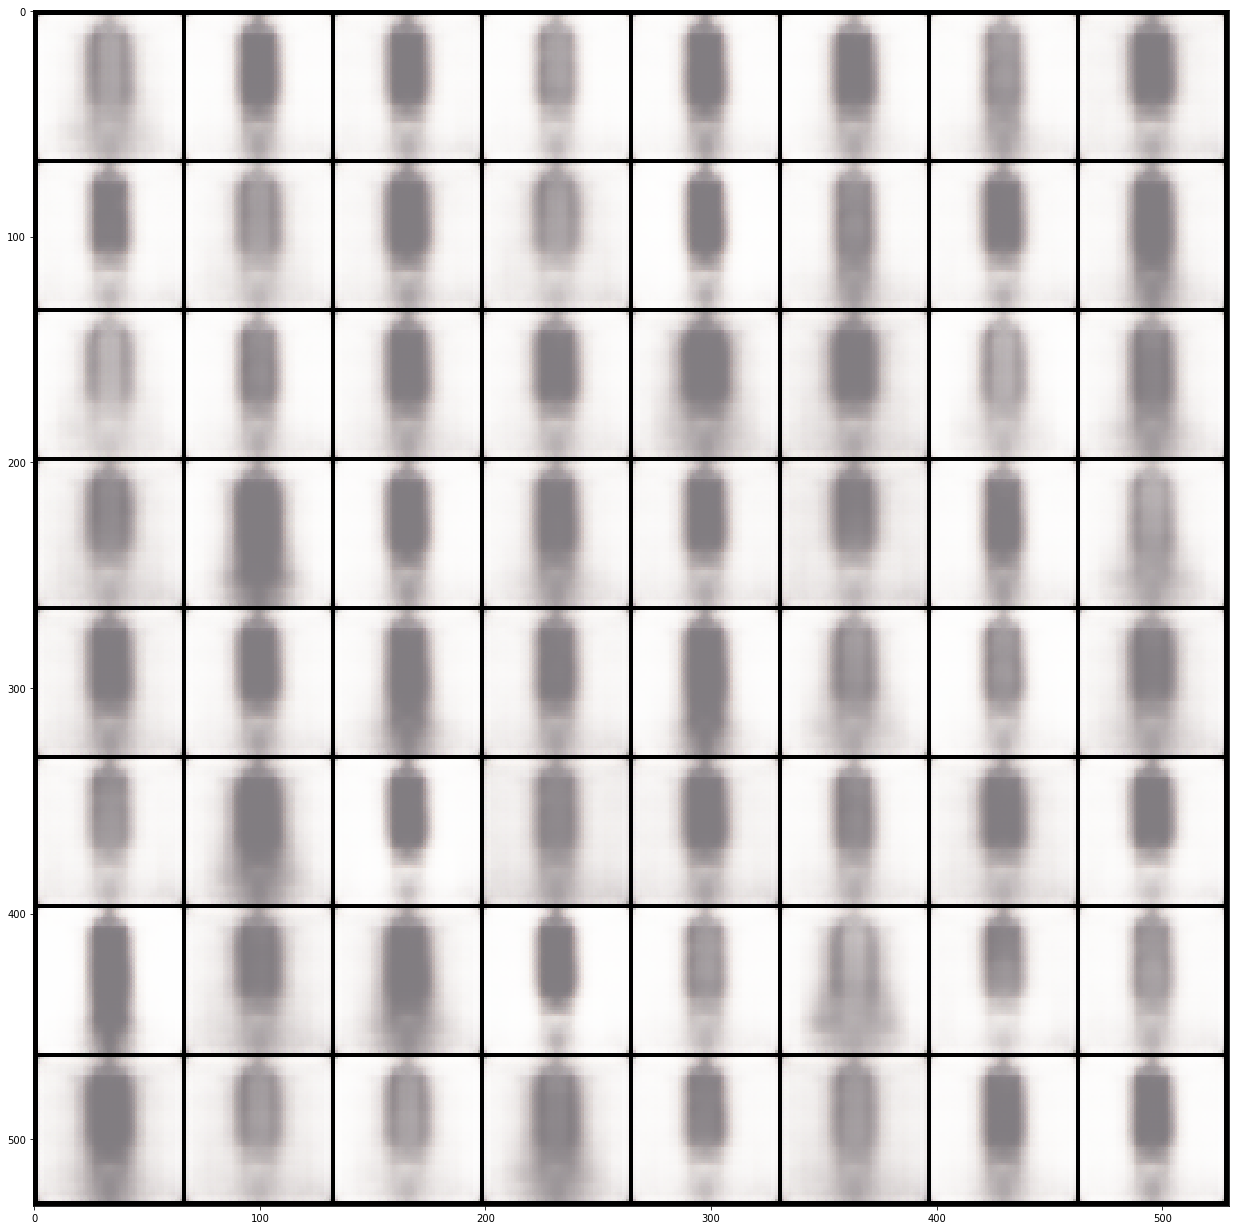

In [26]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=9, cont_axis=1, 
                                       disc_idx=0, disc_axis=0, size=(20, 20))

#plt.imshow(traversals.numpy()[0, :, :], cmap='gray');
plt.figure(figsize=(22,22))
plt.imshow(np.rot90(np.transpose(samples.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/305/64/e10_b2048_c10c10d6d40_traversals9100.png",dpi=200)

### Save Model

In [ ]:
model_name = "rd305_64_e120_b224_c20d20_oct312018.pth"

In [ ]:
torch.save(model.state_dict(),"statedict_" + model_name) # save state dict
torch.save(model, model_name) # save full model

#### Restore Model from State Dict

In [ ]:
sd_model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64))
sd_model.load_state_dict(torch.load("statedict_" + model_name))

#### Restore Full Model
* Note in this case the serialized data is bound to the specific classes and exact directory strucutre used.

In [ ]:
full_model = torch.load(model_name)

In [ ]:
type(full_model)

In [ ]:
type(sd_model)